# 探討 PTT 鄉民對於躺平族的的討論與看法
- 組別：Group 4
- 組員：M124020025 吳安倢 M124020036 吳景煥 M124020023 黃冠輪 M124020020 李培聖
- youtube 影片連結: https://www.youtube.com/watch?v=xV7fIa5O4Qo

### 躺平族介紹：
躺平族是指：放棄遠大的生活目標過著低慾望的生活，收入只需維持生存的最低標準，強調低收入低消費以及及時行樂。

「你人生奮鬥的終點，是別人的起點」，這一句話道出了現在年輕人的掙扎無力感，當你人生不順遂，一路逆風努力了一輩子，發現成就還是不如別人，那還不如對自己好一點，直接躺平！

躺平族這一概念在近年來ptt掀起討論，象徵著對現代社會壓力和期望的一種抗議或無奈的應對方式。透過分析PTT上的討論，可以深入了解台灣社會對這種現象的看法和感受。
根據媒體研究，台灣人使用「躺平」這個次數在「2021年」快速產生！

## 大綱
1. 資料
    - 1.1 資料集介紹
    - 1.2 分析動機
2. 資料前處理
    - 2.1 匯入資料
    - 2.2 清理資料
    - 2.3 jieba斷詞 & 移除停用字
3. 文字雲
    - 3.1 詞頻為前10高的長條圖
    - 3.2 文字雲
4. SnowNLP情緒分析
5. TF-IDF計算
6. 透過結巴斷詞與N-gram幫助建立字典
7. LDA 主題模型
8. 社群網路圖
9. 結論

## 1. 資料

### 資料集介紹

- 資料來源：PTT 閒聊板資料
- 資料集：lie-flat.csv
- 關鍵字：躺平族、躺平、不想努力了
- 資料時間：2021-01-01 到 2024-04-18
- 資料量： 625 篇文章

### 分析動機：
* 躺平主義在強調低收入低消費，會對於國家經濟以及競爭力造成影響
* 世界各地在近年開使出現躺平族，但每個國家面對的困境以及躺平的原因不盡相同
因此我們希望探討台灣躺平族躺平的主因
* 分析躺平族現象對經濟活動、就業市場和消費行為的影響（如不消費、低生產），以及它可能對未來經濟發展的影響
* 透過分析PTT閒聊版上的討論，揭露大眾意見的形成與流動過程。分析媒體如何塑造對躺平族的觀點，以及這些觀點在台灣社會中如何傳播與轉變


## 2. 資料前處理

In [ ]:
# ! pip install pandas
# ! pip install numpy
# ! pip install pyvis
# ! pip install networkx
# ! pip install IPython
# ! pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import math
from functools import reduce
from collections import Counter
from pprint import pprint
from datetime import datetime, timedelta
from collections import Counter, namedtuple

import jieba

import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
# import pyLDAvis.gensim_models
import pyLDAvis.gensim

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="raw_data/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 120

In [ ]:
# import os

# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/sma/Lie_Flat_Project') #切換該目錄
# os.listdir() #確認目錄內容

### 2.1 匯入資料

In [ ]:
#Import the dataset
MetaData = pd.read_csv('raw_data/Lie-Flat.csv')

#將artDate欄位只留下 年/月/日
MetaData['artDate'] = pd.to_datetime(MetaData['artDate']).dt.date

### 2.2 清理資料

In [ ]:
#清理文章內容
clear_df = MetaData.copy()
#去除有包含空值的筆數
clear_df.dropna(axis = 0, how = 'any', inplace = True)

#去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate','dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)


#移除內文中的網址
clear_df['sentence'] = (
    clear_df['artContent']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
    .replace(r'\d+', '', regex = True)
    .replace(r'\n\n','。', regex=True)
    .replace(r'\n' ,',', regex=True)
)

clear_df.head(10)

artUrl                 artTitle  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...            [閒聊]沒有工作的一年~~   
1  https://www.ptt.cc/bbs/China-Drama/M.169899146...              [心得]沒有工作的一年   
2  https://www.ptt.cc/bbs/Gossiping/M.1622344364....    [新聞]中國人「躺平」火爆網路當局慌忙喊停   
3  https://www.ptt.cc/bbs/Gossiping/M.1622810204....          [問卦]我就爛有另一種說法嗎?   
4  https://www.ptt.cc/bbs/Gossiping/M.1622975406....        Re:[問卦]具體來說現在在等什麼   
5  https://www.ptt.cc/bbs/Gossiping/M.1623985925....    [問卦]阿姨我不想努力了算不算躺平的掛??   
6  https://www.ptt.cc/bbs/Gossiping/M.1624777902....         Re:[問卦]現今社會啃老多嗎?   
7  https://www.ptt.cc/bbs/Gossiping/M.1624811888....    [問卦]人生拚三次躺平退出社會競爭可恥嗎?   
8  https://www.ptt.cc/bbs/Gossiping/M.1625541063....  Re:[問卦]好手好腳不工作整天接受施捨的叫?   
9  https://www.ptt.cc/bbs/Gossiping/M.1625642776....    [問卦]台灣的躺平族或家裡蹲是不是比較少？   

      artDate                                         artContent  \
0  2022-05-03  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
1  2023-11-03  因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...   
2  2021-05-30  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...   
3  2021-06-04  在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...   
4  2021-06-06  依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...   
5  2021-06-18  躺平族 尼特族 日本低慾望 韓國袋鼠族....等\n\n在台灣1450所造成的內捲下，名稱還...   
6  2021-06-27  日本就一堆了叫啃老族\n\n美國稱迴力鏢族\n\n中國叫躺平族\n\n台灣也差不多\n\n但...   
7  2021-06-28  我有個朋友\n人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\n人生拚第二次 三年考上公...   
8  2021-07-06  如果用人來看\n\n就是一個自宅警備隊\n\n每天蹲在家不工作\n\n都要靠父母接濟\n\n...   
9  2021-07-07  這邊是跟中國日本比，中國開始流行躺平，那日本\n\n很早就開始有家裡蹲文化，而且老中少都有，...   

                                            sentence  
0  都第集了，,竟然沒人開這一檔閒聊，,這是一部顛覆的都市情感劇，,沒有白富美的女一，,也沒有高...  
1  因為在FB滑到[沒有工作的一年]給打工人的大金句,才開始注意到這部陸劇[沒有工作的一年]。總...  
2  備註請放最後面 違者新聞文章刪除。.媒體來源:,新唐人。.記者署名:,羅婷婷。.完整新聞標題...  
3    在日本有草食男或啃老族。現在中國忽然來了一個躺平族。那有沒有其他的說法比較文雅的。有沒有八卦,  
4  依據人性。. 人是自私的，自己的利益優先考量,. 別人的不幸甜如蜜。但是大家在等的都不一樣。...  
5  躺平族 尼特族 日本低慾望 韓國袋鼠族....等。在台灣所造成的內捲下，名稱還沒有定義。所以...  
6  日本就一堆了叫啃老族。美國稱迴力鏢族。中國叫躺平族。台灣也差不多。但神奇的事如果是上代有錢代...  
7  我有個朋友,人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄,人生拚第二次 三年考上公職 ...  
8  如果用人來看。就是一個自宅警備隊。每天蹲在家不工作。都要靠父母接濟。而且脾氣還很大。覺得自己...  
9  這邊是跟中國日本比，中國開始流行躺平，那日本。很早就開始有家裡蹲文化，而且老中少都有，那台。...

In [ ]:
# 移除網址格式，只留下中文字
clear_df["sentence"] = clear_df["sentence"].str.replace("(http|https)://.*", "", regex=True)
clear_df["artTitle"] = clear_df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
clear_df["sentence"] = clear_df["sentence"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
clear_df["artTitle"] = clear_df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

In [ ]:
clear_df.head()

artUrl           artTitle  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...          閒聊沒有工作的一年   
1  https://www.ptt.cc/bbs/China-Drama/M.169899146...          心得沒有工作的一年   
2  https://www.ptt.cc/bbs/Gossiping/M.1622344364....  新聞中國人躺平火爆網路當局慌忙喊停   
3  https://www.ptt.cc/bbs/Gossiping/M.1622810204....       問卦我就爛有另一種說法嗎   
4  https://www.ptt.cc/bbs/Gossiping/M.1622975406....       問卦具體來說現在在等什麼   

      artDate                                         artContent  \
0  2022-05-03  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
1  2023-11-03  因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...   
2  2021-05-30  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...   
3  2021-06-04  在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...   
4  2021-06-06  依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...   

                                            sentence  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  
1  因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...  
2  備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...  
3        在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比較文雅的有沒有八卦  
4  依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都不一樣所以中產階級在等我...

### 2.3 jieba斷詞 & 移除停用字

In [ ]:
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).str.replace(r'\d+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df.head(10)

artUrl            artTitle  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...           閒聊沒有工作的一年   
1  https://www.ptt.cc/bbs/China-Drama/M.169899146...           心得沒有工作的一年   
2  https://www.ptt.cc/bbs/Gossiping/M.1622344364....   新聞中國人躺平火爆網路當局慌忙喊停   
3  https://www.ptt.cc/bbs/Gossiping/M.1622810204....        問卦我就爛有另一種說法嗎   
4  https://www.ptt.cc/bbs/Gossiping/M.1622975406....        問卦具體來說現在在等什麼   
5  https://www.ptt.cc/bbs/Gossiping/M.1623985925....   問卦阿姨我不想努力了算不算躺平的掛   
6  https://www.ptt.cc/bbs/Gossiping/M.1624777902....          問卦現今社會啃老多嗎   
7  https://www.ptt.cc/bbs/Gossiping/M.1624811888....  問卦人生拚三次躺平退出社會競爭可恥嗎   
8  https://www.ptt.cc/bbs/Gossiping/M.1625541063....   問卦好手好腳不工作整天接受施捨的叫   
9  https://www.ptt.cc/bbs/Gossiping/M.1625642776....  問卦台灣的躺平族或家裡蹲是不是比較少   

      artDate                                         artContent  \
0  2022-05-03  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
1  2023-11-03  因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...   
2  2021-05-30  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...   
3  2021-06-04  在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...   
4  2021-06-06  依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...   
5  2021-06-18  躺平族 尼特族 日本低慾望 韓國袋鼠族....等\n\n在台灣1450所造成的內捲下，名稱還...   
6  2021-06-27  日本就一堆了叫啃老族\n\n美國稱迴力鏢族\n\n中國叫躺平族\n\n台灣也差不多\n\n但...   
7  2021-06-28  我有個朋友\n人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\n人生拚第二次 三年考上公...   
8  2021-07-06  如果用人來看\n\n就是一個自宅警備隊\n\n每天蹲在家不工作\n\n都要靠父母接濟\n\n...   
9  2021-07-07  這邊是跟中國日本比，中國開始流行躺平，那日本\n\n很早就開始有家裡蹲文化，而且老中少都有，...   

                                            sentence  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  
1  因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...  
2  備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...  
3        在日本有草食男或啃老族現在中國忽然來了一個躺平族那有沒有其他的說法比較文雅的有沒有八卦  
4  依據人性人是自私的自己的利益優先考量別人的不幸甜如蜜但是大家在等的都不一樣所以中產階級在等我...  
5  躺平族尼特族日本低慾望韓國袋鼠族等在台灣所造成的內捲下名稱還沒有定義所以乾脆直接問問有沒有比...  
6  日本就一堆了叫啃老族美國稱迴力鏢族中國叫躺平族台灣也差不多但神奇的事如果是上代有錢代啃老就叫...  
7  我有個朋友人生拚第一次讀研究所拚學位拚四年無法拿到學位放棄人生拚第二次三年考上公職做三年後不...  
8  如果用人來看就是一個自宅警備隊每天蹲在家不工作都要靠父母接濟而且脾氣還很大覺得自己都在努力準...  
9  這邊是跟中國日本比中國開始流行躺平那日本很早就開始有家裡蹲文化而且老中少都有那台灣除去疫情下...

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\project\dict\dict.txt ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u12638d280f966ce0f0dac1eae086d443.cache
Loading model cost 0.370 seconds.
Prefix dict has been built successfully.


In [ ]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

artUrl   artTitle     artDate  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   

                                          artContent word  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   第集  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   竟然  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...  沒人開  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   這一  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   閒聊  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   這是  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   一部  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   顛覆  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   都市  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   情感

In [ ]:
# 計算詞頻並轉換為DataFrame
word_counts = pd.DataFrame(pd.value_counts(word_df['word'])).reset_index()
word_counts.columns = ['word', 'count']  # 將列名稱正確設置為 'word' 和 'count'

# 根據 'count' 欄位降序排序
freq_df = word_counts.sort_values(by='count', ascending=False)
freq_df.head(10)

word  count
0   躺平   1225
1   台灣    448
2   就是    439
3   自己    431
4   工作    377
5   現在    353
6   沒有    323
7   不是    318
8   可以    314
9  年輕人    300

In [ ]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]
stopwords_manual = ["台灣","躺平","http","com","imgun","jpg","news"]
stopwords.extend(stopwords_manual)

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

artUrl   artTitle     artDate  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   

                                          artContent word  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   第集  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...  沒人開  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   這一  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   閒聊  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   一部  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   顛覆  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   都市  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   情感  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   富美  
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   富帥

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

'wget' is not recognized as an internal or external command,
operable program or batch file.
'export' is not recognized as an internal or external command,
operable program or batch file.


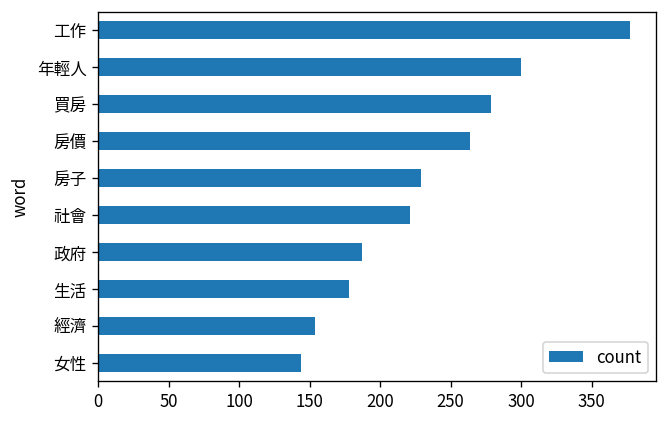

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
word_counts = pd.value_counts(noStop_df['word']).reset_index()
word_counts.columns = ['word', 'count']
freq_df_nostop = word_counts.sort_values(by='count', ascending=False)
freq_df_nostop.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

In [ ]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

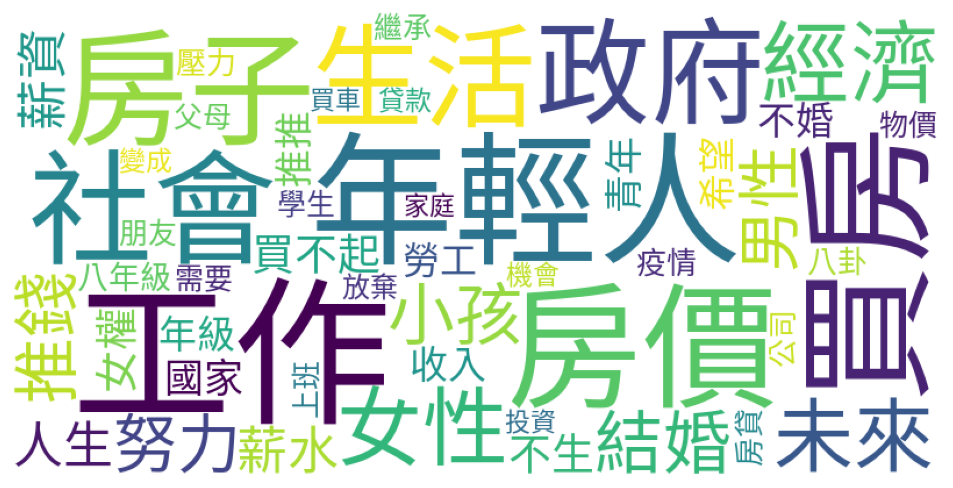

In [ ]:
from wordcloud import WordCloud
FontPath = 'raw_data/SourceHanSansTW-Regular.otf'
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

關於「躺平族」的討論中:

- "工作" 出現頻率最高，這反映了許多人對工作壓力和職場環境的關注。這也可能說明年輕人對當前工作環境的不滿，這正是他們選擇躺平的主要原因之一。

- "買房"、"房價"、"房子"等關鍵詞出現頻率也很高，這表明高房價和購房壓力是年輕人選擇躺平的重要因素。許多年輕人可能感到，即使努力工作，也無法負擔得起房子，從而選擇不再追求傳統的成功標準。

- "社會"和"政府"這兩個詞頻繁出現，顯示出鄉民們對於社會環境和政府政策的討論。他們可能在探討社會制度和政府政策如何影響年輕人的生活選擇，以及是否有需要進行改變來緩解年輕人的壓力。

- "年輕人"、"生活"、"經濟"等詞語的出現，顯示出討論也關注到年輕人的生活態度和經濟狀況。這反映了對於躺平現象的理解和分析，年輕人的經濟壓力和生活態度是重要的討論內容。

In [ ]:
keyword_list = ['政府']
price_selected = MetaData[MetaData['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{price_selected.shape[0]}篇相關貼文")
price_selected.head(3)

政府：88篇相關貼文


system_id                                             artUrl  \
4           5  https://www.ptt.cc/bbs/Gossiping/M.1622975406....   
12         13  https://www.ptt.cc/bbs/Gossiping/M.1626432677....   
16         17  https://www.ptt.cc/bbs/Gossiping/M.1629192932....   

                   artTitle     artDate  artPoster artCatagory  \
4         Re:[問卦]具體來說現在在等什麼  2021-06-06  leondemon   Gossiping   
12  [新聞]出境後號啕大哭23歲大陸男「牆國」出逃  2021-07-16   sunbysea   Gossiping   
16   [新聞]中國推家庭教育法案以改善學業偏重問題  2021-08-17  z041l31l3   Gossiping   

                                           artContent  \
4   依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...   
12  1.媒體來源:\n\n大紀元\n\n2.記者署名:\n\n責任編輯：方曉\n\n3.完整新聞...   
16  1.媒體來源:日本經濟新聞\n\n\n2.記者署名:北京-川手伊織\n\n\n3.完整新聞標...   

                                           artComment           e_ip  \
4   [{"cmtStatus": "噓", "cmtPoster": "jjjjjjs", "c...    27.53.17.75   
12  [{"cmtStatus": "噓", "cmtPoster": "justic125", ...    1.200.88.20   
16  [{"cmtStatus": "→", "cmtPoster": "marktak", "c...  39.12.230.238   

           insertedDate dataSource  
4   2021-06-07 01:25:44        ptt  
12  2021-07-17 00:45:21        ptt  
16  2021-08-18 00:57:16        ptt

## 4. SnowNLP情緒分析

In [ ]:
!pip install snownlp
from snownlp import SnowNLP
sentence_table = pd.read_csv("./zh/sentence_table.csv")

sentiment_date = pd.merge(sentence_table,price_selected[['artUrl','system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

system_id         sentence  \
165          5             依據人性   
166          5  人是自私的，自己的利益優先考量   
167          5         別人的不幸甜如蜜   
168          5       但是大家在等的都不樣   
169          5         所以中產階級在等   

                                                artUrl     artDate dataSource  
165  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt  
166  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt  
167  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt  
168  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt  
169  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt

In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

system_id         sentence  \
165          5             依據人性   
166          5  人是自私的，自己的利益優先考量   
167          5         別人的不幸甜如蜜   
168          5       但是大家在等的都不樣   
169          5         所以中產階級在等   

                                                artUrl     artDate dataSource  \
165  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt   
166  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt   
167  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt   
168  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt   
169  https://www.ptt.cc/bbs/Gossiping/M.1622975406....  2021-06-06        ptt   

     sentimentValue  
165        0.871683  
166        0.954019  
167        0.933026  
168        0.046343  
169        0.785499

<Axes: >

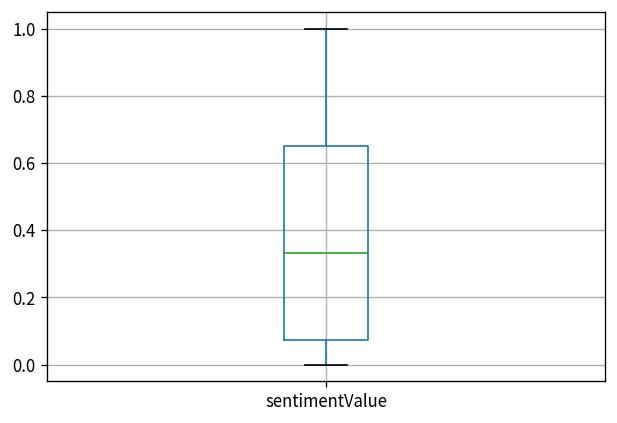

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] = pd.to_datetime(sent_date['artDate']).dt.to_period('M')

# 只保留包含'政府'的句子和 sentimentValue 小於 0.4 的資料
sent_date = sent_date[(sent_date['sentence'].str.contains('政府')) & (sent_date['sentimentValue'] < 0.4)]

# 分組並計算平均值，同時取得每個月的第一個sentence
sentiment_count = sent_date.groupby('artDate').agg({
    'sentimentValue': 'mean',  # 計算sentimentValue的平均值
    'sentence': 'first'       # 取得每個分組中的第一個sentence
}).reset_index()

# 顯示前幾行
sentiment_count.head(100)


artDate  sentimentValue                                 sentence
0   2021-07        0.004140                   裡靜坐，抗議警方暴行，要求政府回應他們的訴求
1   2021-08        0.041204   中國政府這樣親自加入家庭教育的原因，是因為意識到過剩的教育熱已成為嚴重的問題
2   2021-09        0.162288                         沒時間在八卦版上雞蛋挑政府的骨頭
3   2021-10        0.040816     所以說真的要請政府社會住宅多蓋然後條件再放寬點，我相信年輕人就會很有感了
4   2021-11        0.109111                               與其靠政府不如靠佛祖
5   2021-12        0.207213                           不是政府不好，是你自己不爭氣
6   2022-01        0.074039     政府出手打炒房，想藉此抑制房價，從中國盛行的躺平主義也在台灣年級生間發酵
7   2022-02        0.206244                       完整新聞標題政府為年輕人維護居住正義
8   2022-03        0.108995         賴清德說，政府有責任減輕年輕人的負擔，有積極在做，未來會繼續努力
9   2022-04        0.147320                             不要懷疑政府打炒房的決心
10  2022-05        0.017500    台灣的房價漲不回頭，政府打房似乎越打越貴，許多青壯年出社會打拚多年仍買不起
11  2022-06        0.147593                           台灣政府為什麼要為少數人修法
12  2022-07        0.361214     六層樓高的超大看板，寫著感謝台北市政府，祝黃珊珊更上層樓，就這麼掛在台北
13  2022-09        0.095100   聯形式，並結合黨主席柯文哲民眾黨團，地方參選人的聲量，希望喚起政府及國人對於
14  2022-10        0.026457                                 政府都不處理了嗎
15  2022-12        0.140431        全躺平者，屬於賴家，不工作，領政府補助，然後每天在臉書抱怨社會不公
16  2023-01        0.060108    為是主因之，高雄市代銷公會理事長謝哲耀便提議，建議政府與央行能針對首購新婚
17  2023-03        0.072523     那麼躺平族的夢想工作最近有幾個，想問躺平族們，領政府規定最低薪資兩萬六千
18  2023-04        0.203321                              但是要看政府怎麼執行的
19  2023-05        0.080221                               不過政府還是可以訂出
20  2023-06        0.159173                          各種店家因為政府強制的提高薪資
21  2023-07        0.098872                          政府無厘頭罰款和砸廠暴動歡迎您
22  2023-11        0.097212  房屋企劃研究室總監郎美囡表示，政府打炒讓移轉量走低，加上房價過高，躺平族持續增
23  2023-12        0.005590                         對耶這樣想好像就沒有政府的事情了
24  2024-01        0.348494                                政府如不停止斷章取
25  2024-02        0.062785                          以前約年以前政府還不會管太多咧
26  2024-04        0.268340                     認為低利率政策政府標售土地房屋持有成本太

我們查看含有政府且情緒值偏低的句子，確實看到其中含有許多年輕人對於政策的不滿

例如：與其靠政府不如靠佛祖、台灣的房價漲不回頭、政府打房似乎越打越貴、對耶這樣想好像就沒有政府的事情了

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

artDate  sentimentValue
0  2021-06        0.360551
1  2021-07        0.455106
2  2021-08        0.533279
3  2021-09        0.427272
4  2021-10        0.410435

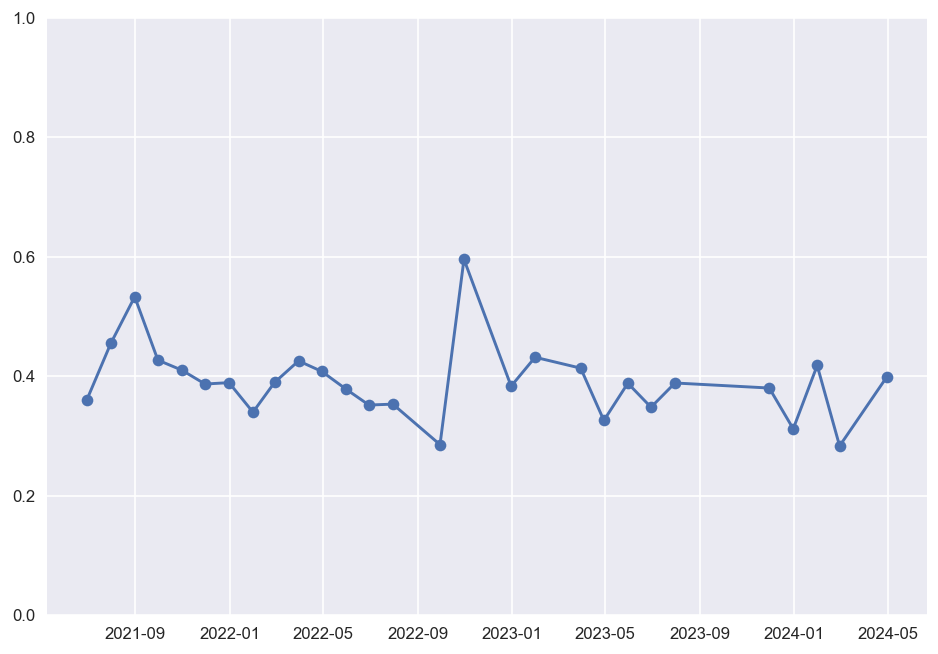

In [ ]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn-v0_8') # or seaborn

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

In [ ]:
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopwords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

## 5. TF-IDF計算

In [ ]:
data = sent_df.copy()
# data.sentence
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

artUrl   artTitle     artDate  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...  閒聊沒有工作的一年  2022-05-03   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   

                                            sentence word  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   第集  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  沒人開  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   這一

In [ ]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

artUrl  total
0    https://www.ptt.cc/bbs/China-Drama/M.165157889...     41
1    https://www.ptt.cc/bbs/China-Drama/M.169899146...     95
2    https://www.ptt.cc/bbs/Gossiping/M.1622344364....    638
3    https://www.ptt.cc/bbs/Gossiping/M.1622810204....      5
4    https://www.ptt.cc/bbs/Gossiping/M.1622975406....     40
..                                                 ...    ...
620  https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....    247
621  https://www.ptt.cc/bbs/prozac/M.1632232347.A.6...     87
622  https://www.ptt.cc/bbs/prozac/M.1667170649.A.7...    102
623  https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...     39
624  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...     26

[625 rows x 2 columns]

In [ ]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

artUrl word  count
0      https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1
1      https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1
2      https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1
3      https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1
4      https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1
...                                                  ...  ...    ...
36210  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...  說不定      1
36211  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   資料      1
36212  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   預訂      1
36213  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   體力      1
36214  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   麻煩      1

[36215 rows x 3 columns]

In [ ]:
lie_flat_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
lie_flat_words

artUrl word  count  total
0      https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1     41
1      https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1     41
2      https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1     41
3      https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1     41
4      https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1     41
...                                                  ...  ...    ...    ...
36210  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...  說不定      1     26
36211  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   資料      1     26
36212  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   預訂      1     26
36213  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   體力      1     26
36214  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   麻煩      1     26

[36215 rows x 4 columns]

In [ ]:
# 計算tf
lie_flat_words_tf_idf = lie_flat_words.assign(tf = lie_flat_words.iloc[:,2]/lie_flat_words.iloc[:,3])
lie_flat_words_tf_idf.head()

artUrl word  count  total  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1     41   
1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1     41   
2  https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1     41   
3  https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1     41   
4  https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1     41   

        tf  
0  0.02439  
1  0.02439  
2  0.02439  
3  0.02439  
4  0.02439

In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = lie_flat_words.groupby(['word'],as_index=False).size()
lie_flat_words_tf_idf = lie_flat_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
lie_flat_words_tf_idf.head()

artUrl word  count  total  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1     41   
1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1     41   
2  https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1     41   
3  https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1     41   
4  https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1     41   

        tf  size  
0  0.02439     1  
1  0.02439    80  
2  0.02439    35  
3  0.02439     1  
4  0.02439     1

In [ ]:
# 計算idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(idf = lie_flat_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))
lie_flat_words_tf_idf = lie_flat_words_tf_idf.drop(labels=['size'],axis=1)
lie_flat_words_tf_idf.head()

artUrl word  count  total  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1     41   
1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1     41   
2  https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1     41   
3  https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1     41   
4  https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1     41   

        tf       idf  
0  0.02439  2.795880  
1  0.02439  0.892790  
2  0.02439  1.251812  
3  0.02439  2.795880  
4  0.02439  2.795880

In [ ]:
# 計算tf*idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(tf_idf = lie_flat_words_tf_idf.iloc[:,4] * lie_flat_words_tf_idf.iloc[:,5])
lie_flat_words_tf_idf.head()

artUrl word  count  total  \
0  https://www.ptt.cc/bbs/China-Drama/M.165157889...   一部      1     41   
1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   人生      1     41   
2  https://www.ptt.cc/bbs/China-Drama/M.165157889...   今年      1     41   
3  https://www.ptt.cc/bbs/China-Drama/M.165157889...   候選      1     41   
4  https://www.ptt.cc/bbs/China-Drama/M.165157889...   劇王      1     41   

        tf       idf    tf_idf  
0  0.02439  2.795880  0.068192  
1  0.02439  0.892790  0.021775  
2  0.02439  1.251812  0.030532  
3  0.02439  2.795880  0.068192  
4  0.02439  2.795880  0.068192

In [ ]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group

artUrl  \
artUrl                                                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   3      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   4      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   7      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   8      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
...                                                                                                     ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36192  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36194  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36198  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36199  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   36207  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   

                                                         word  count  total  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0       一部      1     41   
                                                   3       候選      1     41   
                                                   4       劇王      1     41   
                                                   7       受挫      1     41   
                                                   8       大雨      1     41   
...                                                       ...    ...    ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36192   厭煩      1     26   
                                                   36194   很花      1     26   
                                                   36198   憂鬱      1     26   
                                                   36199  憂鬱症      1     26   
                                                   36207  精神力      1     26   

                                                                tf      idf  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      0.024390  2.79588   
                                                   3      0.024390  2.79588   
                                                   4      0.024390  2.79588   
                                                   7      0.024390  2.79588   
                                                   8      0.024390  2.79588   
...                                                            ...      ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 36192  0.038462  2.79588   
                                                   36194  0.038462  2.79588   
                                                   36198  0.038462  2.79588   
                                                   36199  0.038462  2.79588   
                                                   36207  0.038462  2.79588   

                                                            tf_idf  
artUrl                                                              
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0      0.068192  
                                                   3      0.068192  
                                                   4      0.068192  
                                                   7      0.068192  
                                                   8      0.068192  
...                                                            ...  
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA..

In [ ]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 0     一部  0.068192
                                                   3     候選  0.068192
                                                   4     劇王  0.068192
                                                   7     受挫  0.068192
                                                   8     大雨  0.068192
https://www.ptt.cc/bbs/China-Drama/M.1698991462... 108   金句  0.058861
                                                   45    人生  0.056387
                                                   65    愛情  0.048816
                                                   94    職場  0.044145
                                                   88    答案  0.038771
https://www.ptt.cc/bbs/Gossiping/M.1622344364.A... 277   火爆  0.035058
                                                   128   中共  0.033778
                                                   131   主義  0.025060
                                                   193   學者  0.022138
                                                   225   慌忙  0.021911

計算整個文集中較常 tf-idf 值高的字

In [ ]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(20) # 排序看前十名

word  size
2015  年輕人    16
1935   工作    13
2008   年級    13
809   八年級    13
101   七年級    12
1867   小孩    11
1002   勞工     9
4664   青年     9
636    保全     9
2334   房價     9
349    主義     8
2612   政府     8
216    不婚     8
3728   繼承     8
2250   意義     8
3963   薪資     8
3744   美國     7
2839   有錢     7
2069   廢物     7
1924   屬於     7

## 6.透過結巴斷詞與N-gram幫助建立字典

### 6.1 Bigram

In [ ]:
from nltk import ngrams

In [ ]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
import re
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
MetaData.head(3)
MetaData.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
1          2  https://www.ptt.cc/bbs/China-Drama/M.169899146...   
2          3  https://www.ptt.cc/bbs/Gossiping/M.1622344364....   

                artTitle     artDate   artPoster  artCatagory  \
0          [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
1            [心得]沒有工作的一年  2023-11-03   sgc056613  China_Drama   
2  [新聞]中國人「躺平」火爆網路當局慌忙喊停  2021-05-30      vikk33    Gossiping   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
1  因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...   
2  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...    42.73.152.172   
1  [{"cmtStatus": "推", "cmtPoster": "kirenenko", ...   27.240.162.237   
2  [{"cmtStatus": "→", "cmtPoster": "Imotucc", "c...  118.160.146.219   

          insertedDate dataSource  \
0  2022-05-04 01:06:35        ptt   
1  2023-11-04 01:06:31        ptt   
2  2021-05-31 01:48:03        ptt   

                                            sentence  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  
1  因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...  
2  備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...

In [ ]:
lie_flat_bigram = MetaData.copy()

lie_flat_bigram["word"] =lie_flat_bigram.sentence.apply(bigram_getToken)
lie_flat_bigram = lie_flat_bigram.explode('word')
lie_flat_bigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   

        artTitle     artDate   artPoster  artCatagory  \
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   

          insertedDate dataSource  \
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   

                                            sentence    word  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  第集 沒人開  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  沒人開 這一  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   這一 閒聊

#### 統計最常出現的bigram組合

In [ ]:
# 計算每個組合出現的次數
lie_flat_bigram_count = lie_flat_bigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的bigram組合
fb_filter = list(lie_flat_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
1379   不婚 不生    76
19317  推錢 推錢    55
39524  青年 勞工    40
35008  買房 買車    31
19244  推推 推推    29
19249  推推 推錢    28
19312  推錢 推推    25
29956  結婚 生子    25
1294   不可 轉載    24
36235  轉載 備註    24

### 6.2 Trigram

In [ ]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
lie_flat_trigram = MetaData.copy()

lie_flat_trigram["word"] = lie_flat_trigram.sentence.apply(trigram_getToken)
lie_flat_trigram = lie_flat_trigram.explode('word')
lie_flat_trigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   

        artTitle     artDate   artPoster  artCatagory  \
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   

          insertedDate dataSource  \
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   

                                            sentence       word  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  第集 沒人開 這一  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  沒人開 這一 閒聊  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   這一 閒聊 一部

#### 統計最常出現的trigram組合

In [ ]:
# 計算每個組合出現的次數
lie_flat_trigram_count = lie_flat_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(lie_flat_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
20576  推錢 推錢 推錢    27
1346   不可 轉載 備註    24
20574  推錢 推錢 推推    12
41803  需放 原始 不可    11
39832  違者 刪除 來源    11
7920   原始 不可 轉載    11
36214  請放 違者 刪除    11
4921   備註 請放 違者    11
37203  買房 買車 結婚    10
20464  推推 推推 推推    10

根據 Bigram 以及 Trigram 新增一些段詞於lexicon.txt
* 連結網址
* 青年勞工
* 不可轉載

In [ ]:
jieba.load_userdict('dict\lexicon.txt')

<>:1: DeprecationWarning: invalid escape sequence \l
<>:1: DeprecationWarning: invalid escape sequence \l
C:\Users\USER\AppData\Local\Temp\ipykernel_6296\860765766.py:1: DeprecationWarning: invalid escape sequence \l
  jieba.load_userdict('dict\lexicon.txt')


In [ ]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')
data2.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   

        artTitle     artDate   artPoster  artCatagory  \
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
0  [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...  42.73.152.172   

          insertedDate dataSource  \
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   
0  2022-05-04 01:06:35        ptt   

                                            sentence word  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   第集  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...  沒人開  
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   這一

In [ ]:
from nltk import FreqDist
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

### 6.5 Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [ ]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/China-Drama/M.165157889...   
1          2  https://www.ptt.cc/bbs/China-Drama/M.169899146...   
2          3  https://www.ptt.cc/bbs/Gossiping/M.1622344364....   

                artTitle     artDate   artPoster  artCatagory  \
0          [閒聊]沒有工作的一年~~  2022-05-03  vincentwjs  China_Drama   
1            [心得]沒有工作的一年  2023-11-03   sgc056613  China_Drama   
2  [新聞]中國人「躺平」火爆網路當局慌忙喊停  2021-05-30      vikk33    Gossiping   

                                          artContent  \
0  都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...   
1  因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...   
2  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "larusa", "cm...    42.73.152.172   
1  [{"cmtStatus": "推", "cmtPoster": "kirenenko", ...   27.240.162.237   
2  [{"cmtStatus": "→", "cmtPoster": "Imotucc", "c...  118.160.146.219   

          insertedDate dataSource  \
0  2022-05-04 01:06:35        ptt   
1  2023-11-04 01:06:31        ptt   
2  2021-05-31 01:48:03        ptt   

                                            sentence  \
0  都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...   
1  因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...   
2  備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...   

                                                word  
0  第集 沒人開 這一 閒聊 一部 顛覆 都市 情感 富美 富帥 北上 生活 女二何 小雨 視角...  
1  滑到 工作 打工 金句 注意到 這部 陸劇 工作 總共 本來 打發 沒想到 看著 愛上 感覺...  
2  備註 請放 違者 刪除 來源 唐人 署名 婷婷 標題 中國人 火爆 網路 當局 慌忙 喊停 ...

In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一輩子  一間  七年級  上班  下去  下班  不努力  不可  不婚  不想  ...  青年  青年勞工  面對  韭菜  頭期款  \
0      0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
1      0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
2      0   0    0   0   0   0    0   0   0   0  ...   0     0   2   6    0   
3      0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
4      0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
..   ...  ..  ...  ..  ..  ..  ...  ..  ..  ..  ...  ..   ...  ..  ..  ...   
620    0   0    0   1   0   2    0   0   0   0  ...   0     0   0   0    0   
621    0   0    0   0   1   0    0   0   0   0  ...   0     0   0   0    0   
622    0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
623    0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   
624    0   0    0   0   0   0    0   0   0   0  ...   0     0   0   0    0   

     願意  顯示  香港  高房價  高雄  
0     0   0   0    0   0  
1     0   0   0    0   0  
2     0   0   0    0   0  
3     0   0   0    0   0  
4     0   0   0    0   0  
..   ..  ..  ..  ...  ..  
620   0   0   0    0   0  
621   0   0   0    0   0  
622   0   0   0    0   0  
623   0   0   0    0   0  
624   0   0   0    0   0  

[625 rows x 300 columns]

In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

word1       一輩子        一間       七年級        上班        下去        下班  \
0     一輩子  1.000000 -0.013480  0.017309 -0.032578 -0.008509 -0.021794   
1      一間 -0.013480  1.000000 -0.006601  0.020818 -0.024546  0.034336   
2     七年級  0.017309 -0.006601  1.000000  0.017053 -0.019856 -0.004047   
3      上班 -0.032578  0.020818  0.017053  1.000000  0.022401  0.538141   
4      下去 -0.008509 -0.024546 -0.019856  0.022401  1.000000 -0.017250   
..    ...       ...       ...       ...       ...       ...       ...   
295    願意  0.094958  0.003717 -0.003211  0.050310  0.125856 -0.025380   
296    顯示  0.011356 -0.008510 -0.026400  0.068747  0.103021 -0.031894   
297    香港  0.168018  0.107453 -0.014748 -0.019807  0.078188 -0.006008   
298   高房價  0.129553  0.054366 -0.026414  0.071090  0.171062 -0.042282   
299    高雄 -0.021863  0.100587 -0.017637  0.047435 -0.017427  0.002459   

          不努力        不可        不婚  ...        青年      青年勞工        面對  \
0    0.093136  0.020812  0.085417  ... -0.022111  0.038587  0.041663   
1    0.023962 -0.007937 -0.051538  ... -0.018431 -0.008461 -0.026138   
2    0.016737 -0.033417  0.069726  ... -0.022714 -0.016130 -0.030842   
3    0.025874  0.102237  0.039007  ...  0.058112  0.029624  0.013431   
4    0.005269 -0.023875  0.013919  ...  0.157407 -0.015747  0.117297   
..        ...       ...       ...  ...       ...       ...       ...   
295  0.134123  0.043143 -0.004603  ...  0.015350 -0.007158  0.049733   
296 -0.003228  0.205074  0.020966  ...  0.316642  0.306658  0.193229   
297 -0.017678  0.019334 -0.017963  ...  0.039985 -0.008560  0.011391   
298  0.069530  0.143724  0.149712  ...  0.305762  0.212880  0.397065   
299  0.019143  0.289628 -0.015034  ...  0.181639 -0.010236  0.069334   

           韭菜       頭期款        願意        顯示        香港       高房價        高雄  
0    0.166200 -0.013936  0.094958  0.011356  0.168018  0.129553 -0.021863  
1    0.045763  0.034621  0.003717 -0.008510  0.107453  0.054366  0.100587  
2    0.046033  0.019412 -0.003211 -0.026400 -0.014748 -0.026414 -0.017637  
3   -0.017580 -0.002294  0.050310  0.068747 -0.019807  0.071090  0.047435  
4   -0.030108 -0.047113  0.125856  0.103021  0.078188  0.171062 -0.017427  
..        ...       ...       ...       ...       ...       ...       ...  
295 -0.002378  0.018432  1.000000  0.083170 -0.007716  0.085038  0.044350  
296  0.045288 -0.030603  0.083170  1.000000  0.130391  0.127608  0.106539  
297  0.411551 -0.017095 -0.007716  0.130391  1.000000 -0.018572 -0.009359  
298 -0.000488 -0.040571  0.085038  0.127608 -0.018572  1.000000  0.226539  
299 -0.013065 -0.020444  0.044350  0.106539 -0.009359  0.226539  1.000000  

[300 rows x 301 columns]

In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

word1 word2       cor
11928    署名    內文  1.000000
68439    內文    署名  1.000000
22701    男性    女性  0.998821
60375    女性    男性  0.998821
60376    女權    男性  0.995771
23001    男性    女權  0.995771
22576    女權    女性  0.995539
22875    女性    女權  0.995539
22852    反對    女權  0.987088
15676    女權    反對  0.987088

## 找出和「躺平」以及「政府」相關性最高的 10 的詞彙

In [ ]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "房價")].sort_values(by = ['cor'], ascending = False).head(20)


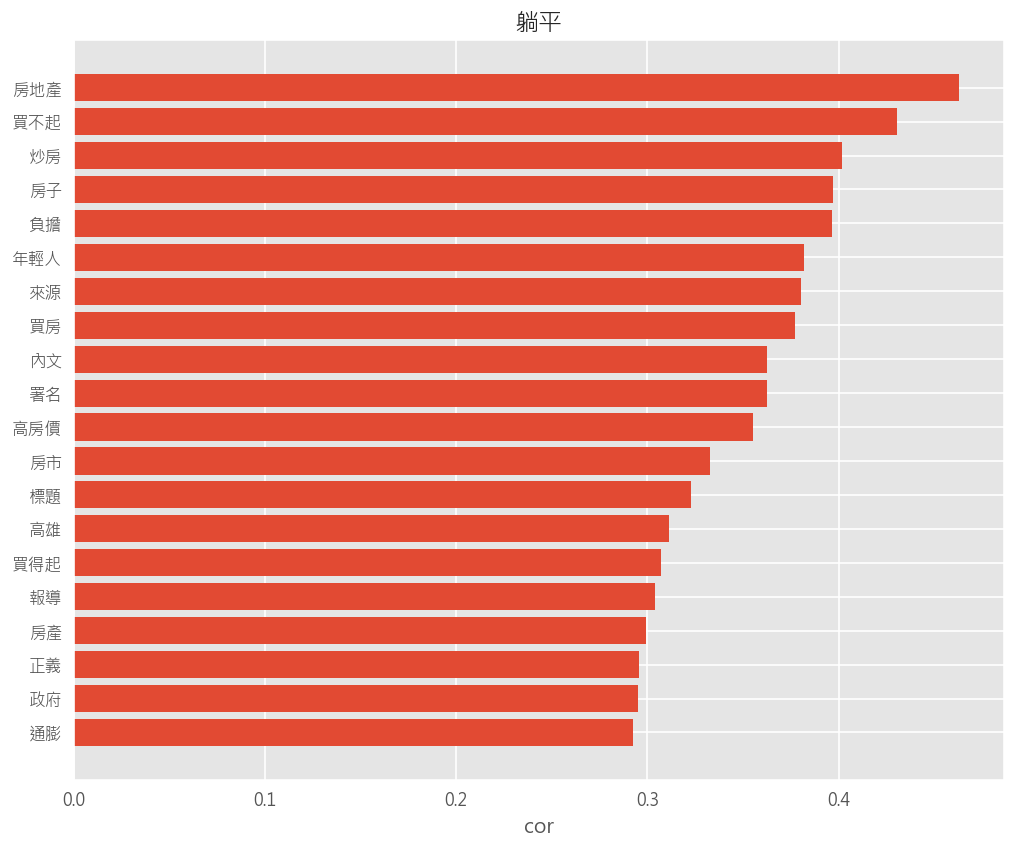

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('躺平')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

### 使用詞彙關係圖畫出詞頻前60且相關性高於0.3的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0      薪水    上班  0.374361
1      不生    不婚  0.896847
2      買車    不婚  0.505111
3      不婚    不生  0.896847
4      買車    不生  0.603008
..    ...   ...       ...
335    男性    需要  0.345500
336    社會    需要  0.373001
337    結婚    需要  0.312215
338    經濟    需要  0.368137
339    職場    需要  0.318996

[340 rows x 3 columns]

In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

In [ ]:
dict = __builtins__.dict

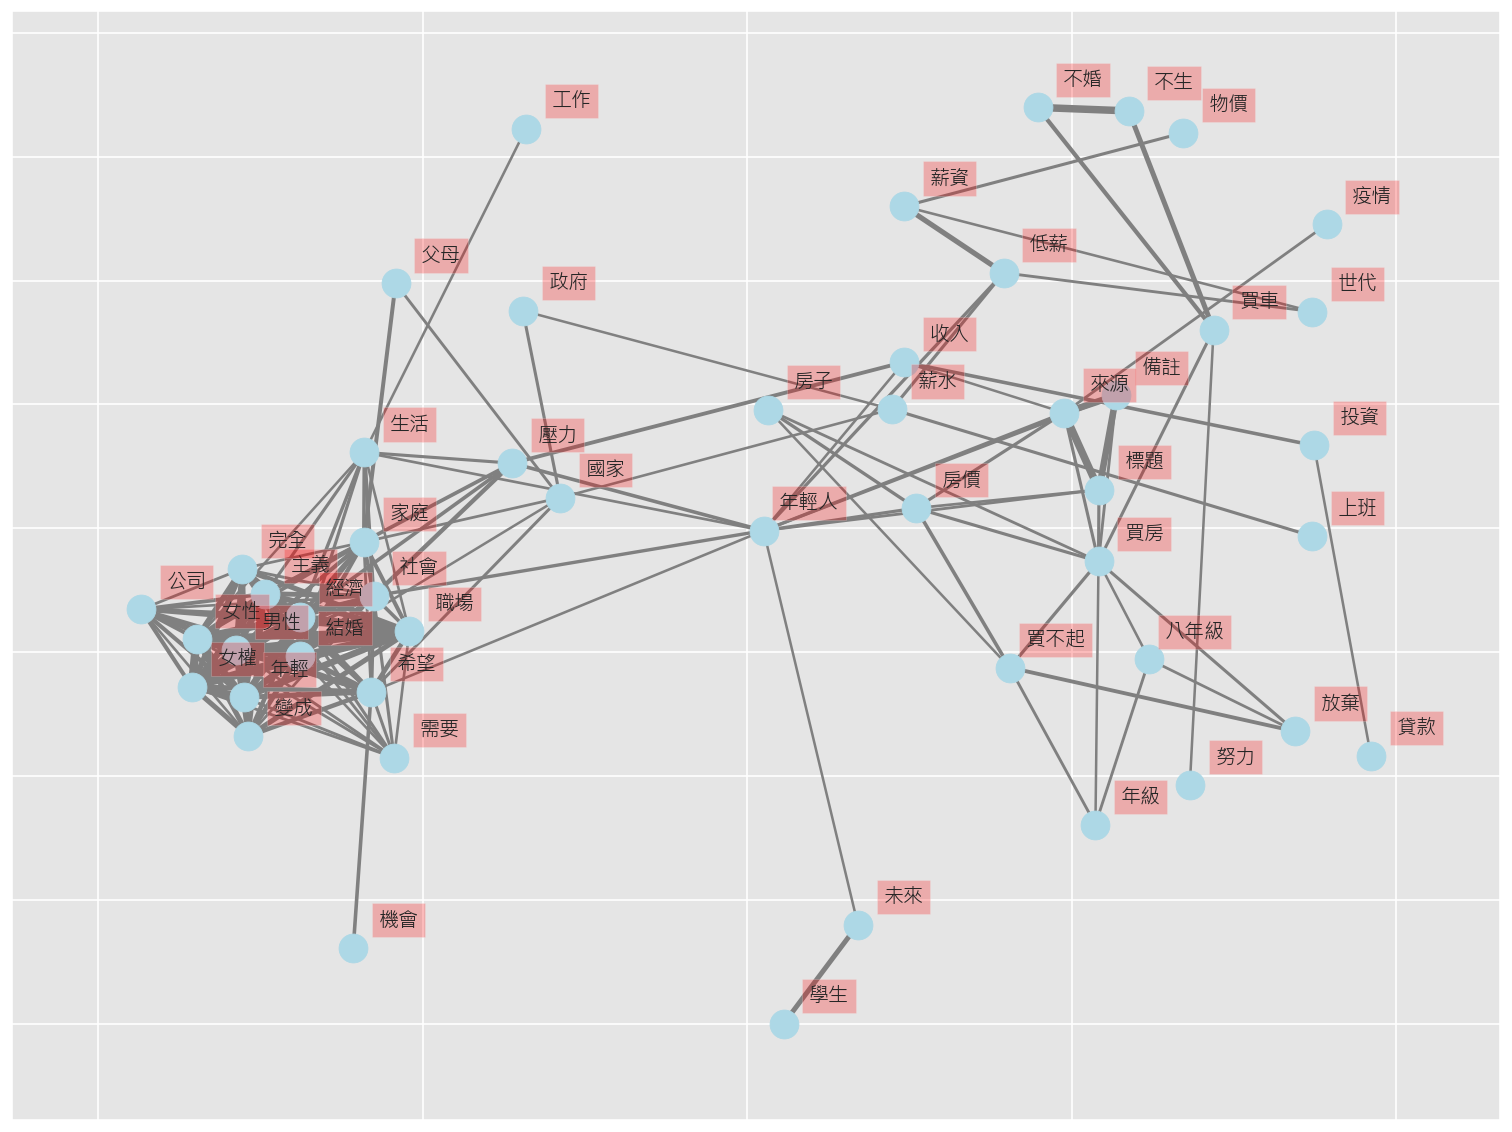

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

## 8. LDA 主題模型

將文章斷詞結果儲存為 list 資料形態，並查看結果

In [ ]:
import pandas as pd
import json
import re

# 定義提取評論信息的函數
def getComtInfo(com):
    cmters, cmt_statuss, cmt_contents = [], [], []
    com = json.loads(com)  # 使用 json.loads 代替 eval
    for i in com:
        cmters.append(i['cmtPoster'])
        cmt_statuss.append(i['cmtStatus'])
        cmt_contents.append(i['cmtContent'])
    return pd.Series([cmters, cmt_statuss, cmt_contents])

# 讀取原始數據
ptt = pd.read_csv("./raw_data/Lie-Flat.csv")

# 應用 getComtInfo 函數並將結果拆分成多個欄位
ptt[['artComter', 'artStatus', 'cmtContents']] = ptt['artComment'].apply(lambda r: getComtInfo(r))

# 確保 artContent 和 cmtContents 欄位的值是字串類型
ptt['artContent'] = ptt['artContent'].astype(str)
ptt['cmtContents'] = ptt['cmtContents'].apply(lambda x: [str(i) for i in x])

# 展平 cmtContents 列表
ptt = ptt.explode('cmtContents')

# 確保所有值都是字串類型
ptt['cmtContents'] = ptt['cmtContents'].astype(str)

# 清理 artContent 和 artTitle 欄位
if 'artContent' in ptt.columns:
    ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
    ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

if 'artTitle' in ptt.columns:
    ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
    ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 清理 cmtContents 欄位
ptt['cmtContents'] = ptt['cmtContents'].apply(lambda x: re.sub(r'(http|https)://.*', '', x))
ptt['cmtContents'] = ptt['cmtContents'].apply(lambda x: re.sub(r'[^\u4e00-\u9fa5]+', '', x))

# 合併欄位
ptt['whole_content'] = ptt.groupby(['system_id', 'artUrl', 'artDate', 'artCatagory', 'artContent'])['cmtContents'].transform(lambda x: ' '.join(x))
ptt = ptt.drop_duplicates(subset=['system_id', 'artUrl', 'artDate', 'artCatagory', 'artContent', 'whole_content'])

# 重新選擇所需欄位
ptt = ptt[['system_id', 'artUrl', 'artDate', 'artCatagory', 'whole_content']]

# 展示結果
ptt.head(10)


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")


# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    if not isinstance(row, str):  # 檢查類型是否為字串
        row = str(row)  # 將非字串類型轉換為字串
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["whole_content"].apply(getToken)

In [ ]:
docs = ptt['words'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<2195 unique tokens: ['也許', '兩人', '加入', '印象', '可愛']...>


將斷詞結果建構語料庫 (corpus)，利用語料庫把每篇文章數字化  
每篇文章、每個詞彙都被賦予一個 ID 及頻率 (word_id，word_frequency)

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

也許: 0
兩人: 1
加入: 2
印象: 3
可愛: 4
喜歡: 5
太多: 6
工作: 7
感覺: 8
感謝: 9
有趣: 10
特別: 11


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pprint(" ".join(ptt['words'].iloc[600]))

('言之有物 給推 藍綠 輪替 需要 社福 防止 小康 掉到 這篇 正解 贊同 一句 心裡話 簡化 父跟國 老師 民進黨 下去 就解 決了 論述 朝向 '
 '民進黨 國民黨 推一個 資源 夠多 骨子 資源 給了 沒用 奇怪 為啥 民進黨 黨部 招攬 人才 柯批 國蔥 簡化 民進黨 真想 高見 打臉 兩個 '
 '低能兒 痛神講 爸媽 阿公 阿嬤 乾脆 帶去 黨部 照顧 好了 先幫 補血 公公 來噓 照顧 弱勢 降低 犯罪率 國外 研究 研究 墮胎 有助於 降低 '
 '犯罪率 避免 低端 製造 相同 階級 小孩 補助 政策 重新 思考 可惜 總統 大位 賴清德')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary.doc2bow(ptt['words'].iloc[600])[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(48, 1),
 (59, 1),
 (115, 1),
 (116, 1),
 (160, 2),
 (171, 1),
 (215, 1),
 (358, 1),
 (368, 1),
 (409, 1)]

In [ ]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus[0][:3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 2), (1, 1), (2, 2)]

In [ ]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_num   perplexity       pmi
0          2  1196.167815 -0.001149
1          3  1193.148631 -0.022086
2          4  1185.656001 -0.032949
3          5  1190.341594 -0.019039
4          6  1190.392321 -0.023656
5          7  1198.170038 -0.040445
6          8  1203.872747 -0.036235
7          9  1208.126764 -0.053820

### 透過指標找出最佳主題數

Pointwise Mutual Information: 自然語言處理中，想要探討兩個字之間是否存在某種關係，數字越大越好。  
perplexity: 評估指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

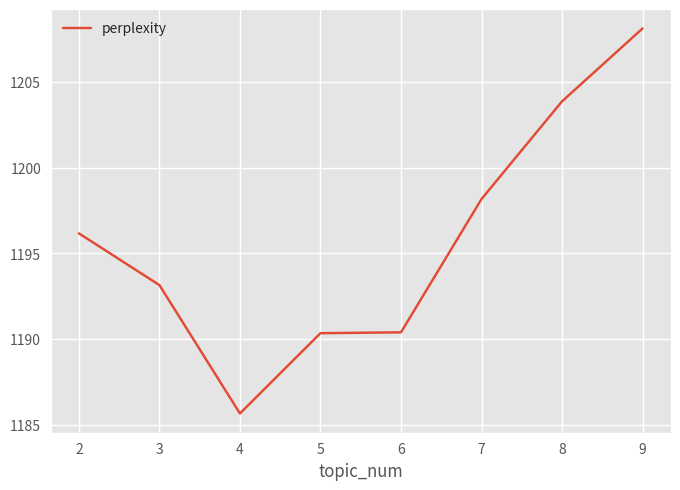

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

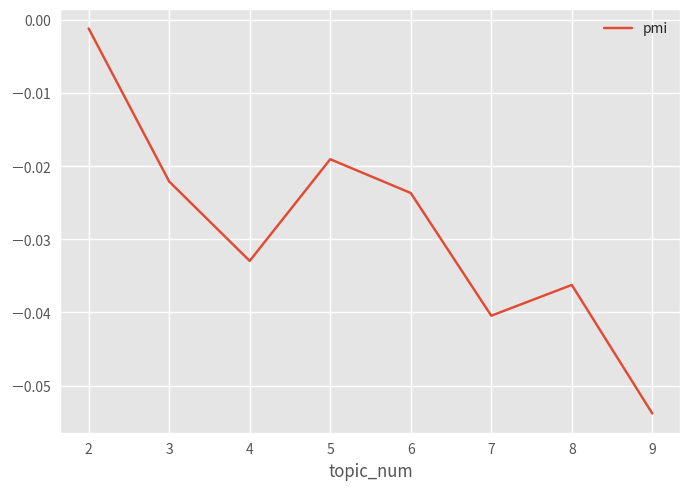

In [ ]:
result.plot.line(x='topic_num', y='pmi')

### 查看 LDA 模型指標

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2048,
        alpha=0.02,
        eta=0.1,
        iterations=1000,
        passes=20 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


花費時間: 183.37081289291382 sec


### 訓練 LDA 模型

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 2048,
    alpha=0.02,
    eta=0.1,
    iterations=1000,
    passes=20 # 訓練次數
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA 視覺化呈現

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.023602 -0.090727       1        1  66.271579
2     -0.129756  0.056709       2        1  21.442525
0      0.153358  0.034018       3        1  12.285896, topic_info=    Term        Freq       Total Category  logprob  loglift
7     工作  442.000000  442.000000  Default  30.0000  30.0000
204   上班  174.000000  174.000000  Default  29.0000  29.0000
468   年級  231.000000  231.000000  Default  28.0000  28.0000
106   買房  444.000000  444.000000  Default  27.0000  27.0000
838   專家  148.000000  148.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
264   整天   24.926808  102.420956   Topic3  -5.4937   0.6836
942   房貸   27.793101  154.347807   Topic3  -5.3848   0.3823
106   買房   32.613274  444.151840   Topic3  -5.2249  -0.5147
69    房子   30.059904  389.480918   Topic3  -5.3064  -0.4649
158   老闆   25.220826  139.050455   Topic3  -5.4820   0.3896

[239 rows x 6 columns], token_table=      Topic      Freq Term
term                      
212       1  0.409743   一代
212       2  0.591851   一代
485       1  0.165415  一千萬
485       3  0.827075  一千萬
462       1  0.008562  七年級
...     ...       ...  ...
115       2  0.080406   階級
2153      1  0.165266   面試
2153      3  0.826330   面試
1400      1  0.984937   香港
1400      2  0.018941   香港

[383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 主題分析
| 主題 | 關鍵字 | 主題議題 |
| --- | --- | --- |
| 1 | 年輕人、房價、炒房、買房、買不起、薪資、未來 | 圍繞著年輕人和房地產市場的挑戰。關鍵議題包括高房價和炒房問題，使得年輕人難以負擔購房。議題還涉及到薪資水平與房價的巨大差距，導致年輕人對未來的擔憂和不確定性。 |
| 2 | 工作、小孩、上班、生活、結婚、賺錢、不婚、人生 | 涉及工作與生活的平衡，尤其是對於已經有小孩或準備要小孩的家庭。議題包含結婚和不婚的選擇，工作和賺錢的壓力，以及這些因素對個人生活品質的影響。 |
| 3 | 年紀、七年級、八年級、努力、經濟、房貸、存款、學生 | 探討不同年齡層，特別是七年級和八年級生在經濟壓力下的生活。議題包括努力工作賺錢、經濟狀況、償還房貸和存款的挑戰。還涉及到學生時期的經濟壓力和對未來的準備。 |

## 8. 社群網路圖


In [ ]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import matplotlib.pyplot as plt
# Show network.png
from IPython.display import Image

In [ ]:
raw_data = pd.read_csv('./Lie-Flat.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/8), random_state=0)
print(raw_data.shape)
raw_data.head()


(77, 11)


system_id                                             artUrl  \
467        468  https://www.ptt.cc/bbs/Gossiping/M.1676222086....   
456        457  https://www.ptt.cc/bbs/Gossiping/M.1674717943....   
214        215  https://www.ptt.cc/bbs/Gossiping/M.1637384613....   
420        421  https://www.ptt.cc/bbs/Gossiping/M.1671620811....   
347        348  https://www.ptt.cc/bbs/Gossiping/M.1654098018....   

                      artTitle              artDate artPoster artCatagory  \
467        Re:[問卦]保全是躺平族的第一志願？  2023-02-13 01:14:44  GA389434   Gossiping   
456    Re:[問卦]《三體》這小說是怎麼孕育出來的?  2023-01-26 15:25:41    takase   Gossiping   
214       Re:[問卦]年輕人以後退休多少錢才夠？  2021-11-20 13:03:30  qaz90427   Gossiping   
420    [新聞]「躺平族」已成時代趨勢網曝4大軟爛類型  2022-12-21 19:06:48    HD0621   Gossiping   
347  Re:[新聞]不逃了？打炒房修法卡關七都預售換約全  2022-06-01 23:40:15  rockok71   Gossiping   

                                            artContent  \
467  看回文一堆說保全不爽工時長\n但一般社區保全約4萬\n幾乎都是退休阿公在當的\n工時就12小...   
456  其實沒那麼單純\n\n\n除了文革之外，所謂黑暗森林法則，其實就是變形的河殤論\n\n或者河...   
214  看你要怎樣退休\n\n這十年大陸房價飆漲\n\n隨便買房兩三千萬台幣都是常態  而且貸款利率...   
420  你算哪一種？「躺平族」已成時代趨勢 網曝4大軟爛類型\n\nTVBS\n\n林保宏報導\n\...   
347  2021全台轉移棟數約35萬棟\n台灣政府為什麼要為少數人修法\n是吧?\n修法會讓房價降\...   

                                            artComment           e_ip  \
467  [{"cmtStatus": "推", "cmtPoster": "XI", "cmtCon...  1.160.236.155   
456  [{"cmtStatus": "→", "cmtPoster": "StylishTrade...           None   
214  [{"cmtStatus": "推", "cmtPoster": "spirit119", ...   110.87.165.6   
420  [{"cmtStatus": "推", "cmtPoster": "wwvvkai", "c...  36.235.141.57   
347  [{"cmtStatus": "推", "cmtPoster": "lululun", "c...  125.228.79.53   

            insertedDate dataSource  
467  2023-02-13 01:23:23        ptt  
456  2023-01-27 01:19:30        ptt  
214  2021-11-22 00:24:48        ptt  
420  2022-12-22 01:32:11        ptt  
347  2022-06-02 01:38:05        ptt

In [ ]:
#parse comment

def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

{'cmtStatus': '推', 'cmtPoster': 'XI', 'cmtContent': ':白天還是會有事晚上才會比較沒事', 'cmtDate': '2023-02-13 01:39:00'}
{'cmtStatus': '推', 'cmtPoster': 'agneswhat', 'cmtContent': ':白天的保全要登記包裹大社區的話很多', 'cmtDate': '2023-02-13 01:50:00'}
{'cmtStatus': '→', 'cmtPoster': 'BIGBBB', 'cmtContent': ':有的還要倒垃圾陣沒想像中爽', 'cmtDate': '2023-02-13 01:52:00'}
{'cmtStatus': '噓', 'cmtPoster': 'PeterSu1983', 'cmtContent': ':你沒當過吧', 'cmtDate': '2023-02-13 02:36:00'}
{'cmtStatus': '推', 'cmtPoster': 'nashQ', 'cmtContent': ':社區保全其實很辛苦看一些瘋住戶在那邊有', 'cmtDate': '2023-02-13 02:48:00'}
{'cmtStatus': '→', 'cmtPoster': 'nashQ', 'cmtContent': ':繳管理費是大爺...', 'cmtDate': '2023-02-13 02:48:00'}
{'cmtStatus': '推', 'cmtPoster': 'kerorokuzo', 'cmtContent': ':你要不要去站看看台gg的保全??', 'cmtDate': '2023-02-13 03:00:00'}
{'cmtStatus': '推', 'cmtPoster': 'pc011630', 'cmtContent': ':gg太硬，什麼都管，一樣賺那麼一點，不', 'cmtDate': '2023-02-13 04:09:00'}
{'cmtStatus': '→', 'cmtPoster': 'pc011630', 'cmtContent': ':要去自找麻煩', 'cmtDate': '2023-02-13 04:09:00'}
{'cmtStatus': '

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
social_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
social_data.head(10)


artUrl artPoster    artComter  \
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434           XI   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434    agneswhat   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434       BIGBBB   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434  PeterSu1983   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434        nashQ   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434        nashQ   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434   kerorokuzo   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434     pc011630   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434     pc011630   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....  GA389434      lionsss   

    artStatus  
467         推  
467         推  
467         →  
467         噓  
467         推  
467         →  
467         推  
467         推  
467         →  
467         推

In [ ]:
social_data

artUrl    artPoster  \
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....     GA389434   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....     GA389434   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....     GA389434   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....     GA389434   
467  https://www.ptt.cc/bbs/Gossiping/M.1676222086....     GA389434   
..                                                 ...          ...   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   

        artComter artStatus  
467            XI         推  
467     agneswhat         推  
467        BIGBBB         →  
467   PeterSu1983         噓  
467         nashQ         推  
..            ...       ...  
616  DRagonFans87         推  
616        qmaper         推  
616       daueing         噓  
616       MM79979         推  
616       MM79979         →  

[2812 rows x 4 columns]

### 可以看到, 就算我們已經把原本的資料取1/8, 每個貼文下還是有很多留言, 可見大家對於躺平族討論是蠻踴躍的。

### 所以我們決定只分析討論度前10的貼文

In [ ]:
# count how many comments under each article
social_data['artUrl'].value_counts()

# select top 10 articles with most comments
social_data = social_data[social_data['artUrl'].isin(social_data['artUrl'].value_counts().head(10).index)]
social_data.head()

artUrl artPoster artComter  \
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621   wwvvkai   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621  AnpingTW   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621   FA88124   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621   Hfy0920   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621   Hfy0920   

    artStatus  
420         推  
420         推  
420         推  
420         →  
420         →

In [ ]:
social_data

artUrl    artPoster  \
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....       HD0621   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....       HD0621   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....       HD0621   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....       HD0621   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....       HD0621   
..                                                 ...          ...   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   
616  https://www.ptt.cc/bbs/Gossiping/M.1711788227....  diefishfish   

        artComter artStatus  
420       wwvvkai         推  
420      AnpingTW         推  
420       FA88124         推  
420       Hfy0920         →  
420       Hfy0920         →  
..            ...       ...  
616  DRagonFans87         推  
616        qmaper         推  
616       daueing         噓  
616       MM79979         推  
616       MM79979         →  

[1650 rows x 4 columns]

In [ ]:
# 建立邊的資料
import random


po_df = social_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]
re_df = social_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]



def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)



In [ ]:
re_df

src                                                dis  weight  \
0            A0908  https://www.ptt.cc/bbs/Gossiping/M.1636371399....       2   
1         A80211ab  https://www.ptt.cc/bbs/Gossiping/M.1691051598....      -1   
2         AKai2210  https://www.ptt.cc/bbs/Gossiping/M.1711788227....       2   
3       AMDMARSHAL  https://www.ptt.cc/bbs/Gossiping/M.1632992724....       0   
4       AMDMARSHAL  https://www.ptt.cc/bbs/Gossiping/M.1691051598....      -1   
...            ...                                                ...     ...   
1079       zsp8084  https://www.ptt.cc/bbs/Gossiping/M.1655729228....       2   
1080        zx8967  https://www.ptt.cc/bbs/Gossiping/M.1636371399....       1   
1081        zzoohh  https://www.ptt.cc/bbs/Gossiping/M.1655729228....       2   
1082  zzzzzzzzzzzy  https://www.ptt.cc/bbs/Gossiping/M.1636371399....       1   
1083  zzzzzzzzzzzy  https://www.ptt.cc/bbs/Gossiping/M.1655729228....       1   

      color  
0     green  
1       red  
2     green  
3       red  
4       red  
...     ...  
1079  green  
1080  green  
1081  green  
1082  green  
1083  green  

[1084 rows x 4 columns]

In [ ]:
import pyvis
from PIL import Image

In [ ]:
# 人為綠色節點
# po文為橘色節點

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

netWork.save_graph('network.html')

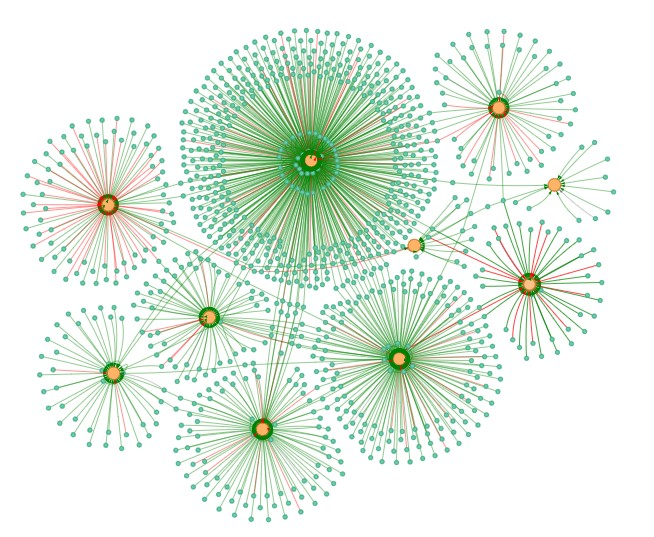

In [ ]:
Image.open('network.jpg')

### 可以看到右下方一個節點的評論中含有很多紅線, 所以我們決定進去貼文看是什麼原因導致這樣的結果。

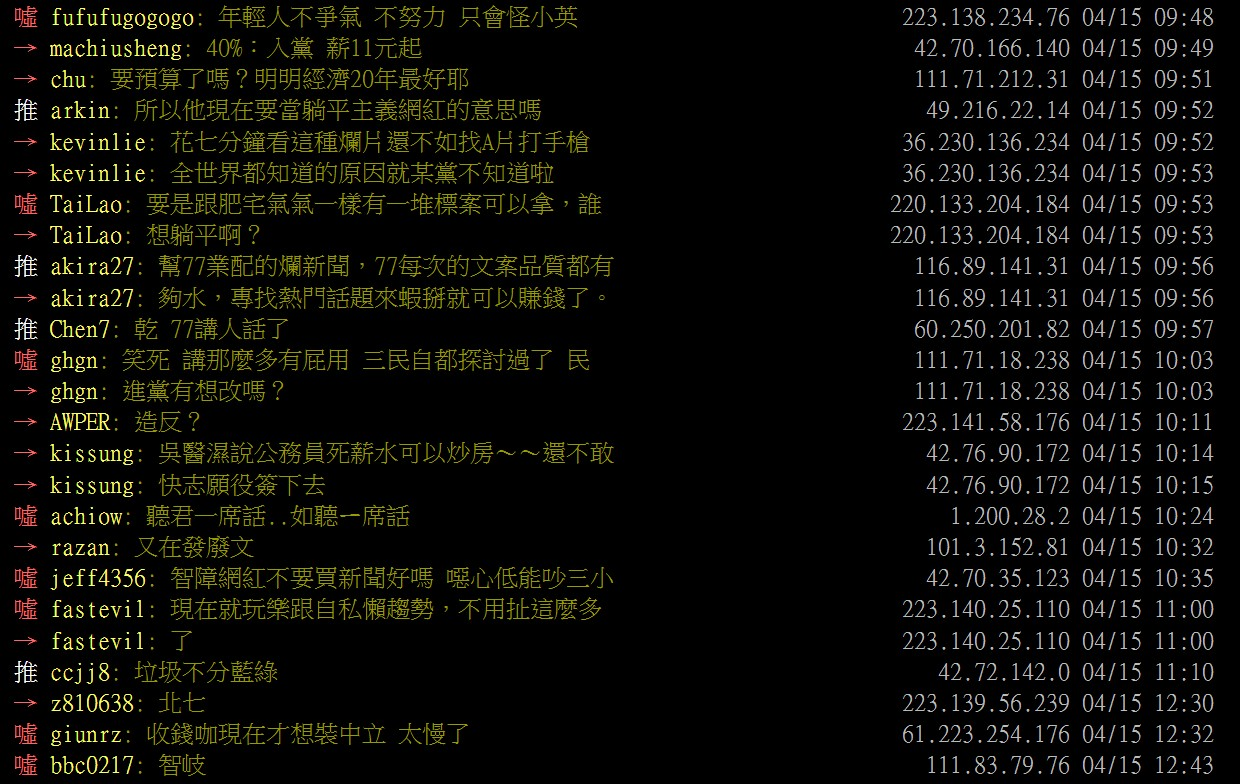

In [ ]:
# Show ptt
Image.open('ptt.jpg')

### 結果發現這個貼文是關於一個網紅對於為什麼年輕人會想躺平所做的分析, 但他說的東西是大家已知的事實,有點像在講廢話, 所以很多人都噓這篇貼文。

In [ ]:
pos_cmt = social_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

artUrl artPoster    artComter  \
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621      wwvvkai   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621     AnpingTW   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621      FA88124   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621      Hfy0920   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621      Hfy0920   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621  monarch0301   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621  monarch0301   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621      q210216   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621  monarch0301   
420  https://www.ptt.cc/bbs/Gossiping/M.1671620811....    HD0621  monarch0301   

    artStatus  
420         推  
420         推  
420         推  
420         →  
420         →  
420         推  
420         →  
420         噓  
420         →  
420         →

In [ ]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

artComter    artPoster  score
0            A0908       KobeNi      2
2         AKai2210  diefishfish      2
3       AMDMARSHAL    butten986      0
5            AMDX6         wiki      1
6            AWPER     LeeSeDol      1
...            ...          ...    ...
1079       zsp8084         wiki      2
1080        zx8967       KobeNi      1
1081        zzoohh         wiki      2
1082  zzzzzzzzzzzy       KobeNi      1
1083  zzzzzzzzzzzy         wiki      1

[970 rows x 3 columns]

In [ ]:
pers = np.unique(pos_cmt[['artComter', 'artPoster']])
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T



(928, 928)


In [ ]:
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array,node_id:list,node_type:list=None,node_value:list = None,directed = True,edge_color=None) -> pyvis.network.Network:

  if directed != True:
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    else:
      print('matrix is not Symmetric')
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  else:
    node_color_map = {}
    for i in set(node_type):
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)
  if edge_color == None:
    edge_color = random_color()
  edge_color = random_color()
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')

  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net


In [ ]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')



In [ ]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type)

net.save_graph('pers_network.html')

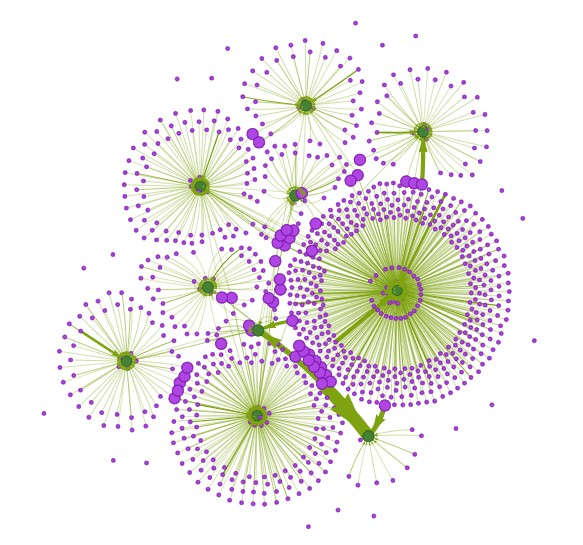

In [ ]:
## Show pers_netWork.png
Image.open('pers_network.jpg')

### 可以看到裡面有蠻多粗的箭頭的節點, 代表討論度很高, 可能是這個版比較多意見的使用者

### 接下來, 我們想看看在這幾篇文章中, 是否能找出連結社群的人, 這些人的特徵應該是betweeness 很高, 代表他們很常在各個文章下留言

In [ ]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(mat_s)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

In [ ]:
node_value = []
for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.save_graph("./bet_netWork.html")

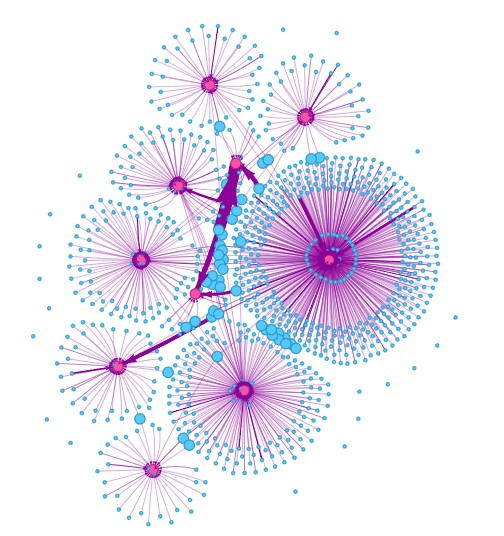

In [ ]:
Image.open('between.jpg')

### 可以從上圖看到, 有蠻多in between的節點, 中間還有幾個的po文者同時也是評論者, 說明這個版別的人都蠻積極討論的,

### 接下來, 我們來看看最大subgraph 的圖的measure

In [ ]:
# 計算max subgraph
G = nx.Graph(mat_s)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
sub_mat = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]

In [ ]:
net = matPresentGraph(mat=sub_mat,node_id=sub_pers,directed=False)
net.save_graph("./max_sub.html")

matrix is Symmetric


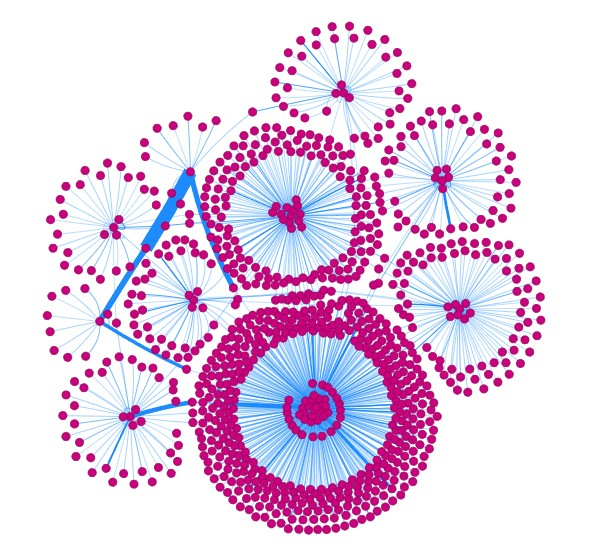

In [ ]:
Image.open('sub.jpg')

### 所有文章都有被保留下來。

### Transitivity

In [ ]:
nx.transitivity(nx.Graph(sub_mat))

0

### 由於節點太多, closure趨近於0。

### Density

In [ ]:
nx.density(nx.Graph(sub_mat))

0.002292299714552953

### Density 也是合理, node那麼多, 但大多數都只會連上文章

### Diameter

In [ ]:
nx.diameter(nx.Graph(sub_mat))

6

### Diameter 是6, 代表最遠的兩個node 之間只間隔了6個點, 是符合 Small World Graph的。

### Average shortest path

In [ ]:
nx.average_shortest_path_length(nx.Graph(sub_mat))

3.545698182153017

### Clustering

In [ ]:
nx.average_clustering(nx.Graph(sub_mat))

0.0

## 9. 結論

###  分析結果

* 我們透過每日發文數量趨勢圖找出躺平主義開始傳入台灣的時間，以及躺平主義2021年9月台灣引發熱意的原因
  * 2021年4月：百度貼吧 一則 "躺平及是正義" 的貼文衝上熱搜，躺平該詞隨後襲捲中國各大社群平台。
  * 2021年9月：中國恆大風暴經濟低迷，躺平主義持續發酵。
  * 2021年9月 ~ 2022年1月：三級警戒不斷延長，許多服務業不堪虧損增加裁員或是延長無薪假，許多年輕人失去收入看不到未來，躺平主義開始受到台灣年輕人關注。

* 透過Pearson correlation 計算出詞彙相關性並取出與躺平相關性前20的字詞，結合辭彙關係圖，我們可以推估出台灣年輕人躺平的理念就是不不買房不結婚不生小孩以及崇尚自由

- 經濟壓力：高房價和低薪水是年輕人選擇躺平的重要原因，反映了他們在現實經濟壓力下的無奈選擇。
- 生活選擇：年輕人對傳統生活方式的抗拒，體現在不婚、不生、放棄等選擇上，這些選擇是對現實壓力的一種反抗。
- 社會與家庭影響：家庭的期望和社會的成功定義對年輕人的選擇產生了重要影響，這也是他們選擇躺平的一個原因。
- 未來不確定性：對於未來的不確定性和焦慮，使得年輕人對於是否努力追求傳統成功目標感到猶豫和迷茫。
- 社會議題影響：疫情等社會議題的影響，加劇了年輕人的生活壓力，進一步促使他們選擇躺平。

總結：年輕人選擇躺平的現象反映了多方面的原因和影響。高房價和低薪水帶來的經濟壓力，使得他們在現實面前感到無奈，進而選擇放棄傳統的奮鬥目標。此外，年輕人對傳統生活方式的抗拒，體現在不婚、不生、以及其他與社會期待相反的生活選擇上，這些選擇也是他們面對現實壓力的一種反抗形式。家庭的期望和社會對成功的定義，進一步加重了他們的心理負擔，成為促使他們選擇躺平的因素之一。對於未來的不確定性和焦慮，使得他們對於是否努力追求傳統成功目標感到猶豫和迷茫。最後，疫情等社會議題的影響，加劇了年輕人的生活壓力，使得他們更加傾向於選擇躺平來應對這些挑戰。在這樣的背景下，躺平成為了許多年輕人面對複雜現實的一種應對策略。